In [16]:
from qiskit_nature.second_q.drivers import Psi4Driver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit.primitives import Estimator
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
import time

Creating molecular configuration in Psi4Driver format. This configuration represents the positions of molecules' nucleus.

In [17]:
molecule_config = """
molecule beh2 {
  0 1
  Be 0.0 0.0 0.0
  H 0.0 0.0 1.32
  H 0.0 0.0 -1.32
}

set basis sto-3g
"""

Creating instance of driver and problem from qiskit Nature library.

In [31]:
driver = Psi4Driver(config=molecule_config)
problem = driver.run()

As seen in the output, increasing number of electrons in the system results with complex ansatz.

In [35]:
mapper = ParityMapper()
ansatz = UCCSD(
    num_spatial_orbitals,
    num_electrons,
    mapper,
    initial_state=HartreeFock(
        num_spatial_orbitals,
        num_electrons,
        mapper,
    ),
)
print(ansatz)

     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                             ├
«     │                                                                                              │
«q_1: ┤1                                                                                             ├
«     │                                                                                              │
«q_2: ┤2                                                                                             ├
«     │                                                                                              │
«q_3: ┤3                                                                                             ├
«     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[

In order to reduce complexity of ansatz, the mapping method is specified.

In [40]:
num_electrons = (3, 3)
num_spatial_orbitals = 4

In [41]:
transformer = ActiveSpaceTransformer(num_electrons, num_spatial_orbitals)
problem = transformer.transform(problem)

In [42]:
hamiltonian = problem.hamiltonian.second_q_op()

In [43]:
mapper = ParityMapper(num_particles=num_electrons)
mapper = problem.get_tapered_mapper(mapper)

In [44]:
ansatz = UCCSD(
    num_spatial_orbitals,
    num_electrons,
    mapper,
    initial_state=HartreeFock(
        num_spatial_orbitals,
        num_electrons,
        mapper,
    ),
)

As seen in the output, the ansatz of the problem is now reduced. This method also reduces the computation time.

In [45]:
print(ansatz)

     ┌───────────────────────────────────────┐
q_0: ┤0                                      ├
     │                                       │
q_1: ┤1                                      ├
     │  EvolvedOps(t[0],t[1],t[2],t[3],t[4]) │
q_2: ┤2                                      ├
     │                                       │
q_3: ┤3                                      ├
     └───────────────────────────────────────┘


In order to find minimum energy of the molecule the bond length should be determined. In order to achieve that, the distance between hydrogen and beryll atom is modified and the ground state energy calculated in every step.

In [26]:
def my_solver(distances):
    energies = []
    computation_time = []
    for distance in distances:
        start_time = time.time()

        # Define the molecule with the updated distance
        molecule_config = "molecule beh2 {\n  0 1\n  Be  0.0 0.0 0.0\n  H  0.0 0.0 " + str(
            distance) + "\n  H  0.0 0.0 " + str(-distance) + "\n}\n\nset {\n  basis sto-3g\n}"

        # Creating an instance of Psi4 Driver using Hydrogen molecule configuration
        driver = Psi4Driver(config=molecule_config)

        # Creating problem
        problem = driver.run()

        # Reducing problem complexity by using fewer orbitals
        num_electrons = (3, 3)
        num_spatial_orbitals = 4

        # Transforming problem into a new one by using molecular properties
        transformer = ActiveSpaceTransformer(num_electrons, num_spatial_orbitals)
        problem = transformer.transform(problem)

        # Creating hamiltonian by using second quantization operators
        hamiltonian = problem.hamiltonian.second_q_op()

        # Creating an instances of mapper
        mapper = ParityMapper(num_particles=num_electrons)
        mapper = problem.get_tapered_mapper(mapper)

        # Creating ansatz
        ansatz = UCCSD(
            num_spatial_orbitals,
            num_electrons,
            mapper,
            initial_state=HartreeFock(
                num_spatial_orbitals,
                num_electrons,
                mapper,
            ),
        )

        # Mapping second quantization operators into qubit operators
        qubit_h = mapper.map(hamiltonian)

        # Creating an instance of optimizer
        optimizer = L_BFGS_B()

        # Creating an instance of estimator which simulates quantum computer behaviour on local computer
        estimator = Estimator()

        # Set up the VQE algorithm
        vqe = VQE(Estimator(), ansatz=ansatz, optimizer=optimizer)

        # Computing ground state energy value
        calc = GroundStateEigensolver(mapper, vqe)
        result = calc.solve(problem)

        # Append the result to the list
        energies.append(result.total_energies[0])

        end_time = time.time()

        elapsed_time = end_time - start_time

        computation_time.append(elapsed_time)

    return energies, computation_time

In [27]:
energies, computation_time = my_solver(distances)

In [28]:
mean_elapsed_time = np.mean(computation_time)
print(f"Elapsed Time: {mean_elapsed_time} seconds")

Elapsed Time: 9.477162755768875 seconds


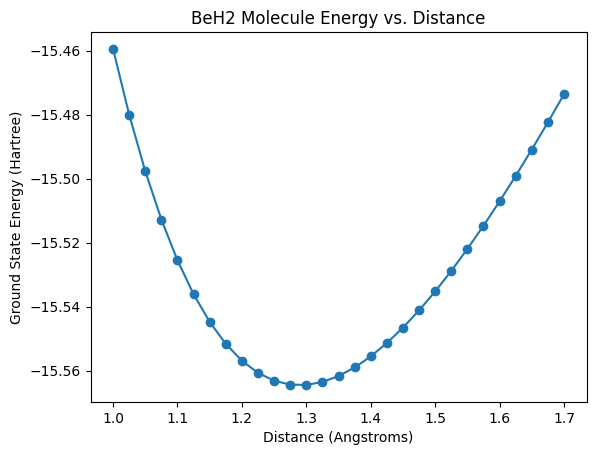

In [29]:
plt.plot(distances, energies, marker='o')
plt.xlabel('Distance (Angstroms)')
plt.ylabel('Ground State Energy (Hartree)')
plt.title('BeH2 Molecule Energy vs. Distance')
plt.show()